# Text Representation

In [5]:
import pandas as pd

In [6]:
# Fetch preprocessed data
model_data = pd.read_csv("/content/keywords.csv")
model_data.head()

,Id,Name,Language,keywords
0,1030195,morning star,eng,h._rider_haggard 1st_world_library_-_literary...
1,1090099,kitty's class day and other stories,eng,louisa_may_alcott 1st_world_library_-_literar...
2,1013522,the art of french kissing,eng,kristin_harmel 5_spot_pub eng emma paris fren...
3,1003725,"comet in moominland (the moomins, #2)",eng,"the_moomins,_#2 tove_jansson a_&_c_black eng m..."
4,1099901,the boy who cried horse,en-GB,terry_deary a_&_c_black en-GB acheron greeks ...


---
### Vectorize the keywords summary using TF-IDF
- Convert the keywords for each book into a numeric vector, based on the frequency of each word in the book's keywords
- Keep token pattern such that tokens with underscore are not ignored.
- Remove tokens occuring less than 3 times or occur in more than 60% of the documents (common tokens).
- Remove english language stop words

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word',
                        min_df=3,
                        max_df = 0.6,
                        stop_words="english",
                        encoding = 'utf-8',
                        token_pattern=r"(?u)\S\S+")
tfidf_encoding = tfidf.fit_transform(model_data["keywords"])

In [8]:
import joblib

# Save the TF-IDF model
joblib.dump(tfidf, '/content/tfidf_model.pkl')

['/content/tfidf_model.pkl']

In [9]:
# Preview first 100 words in the vocabulary
print(tfidf.get_feature_names_out()[1:100])

['1830s' '1863' '1880s' '1914' '1915' '1920s' '1930s' '1937' '1939' '1940'
 '1941' '1942' '1944' '1945' '1949' '1950s' '1960s' '1963' '1965' '1996'
 '1997' '1999' '2005' '60s' 'abacus' 'abbot' 'abby' 'abbys' 'abducted'
 'abigail' 'academic' 'academy' 'accused' 'ace' 'ace_books' 'activist'
 'activities' 'actor' 'actors' 'actress' 'adam' 'addiction'
 'addison-wesley_professional' 'addison_wesley_publishing_company'
 'admiral' 'adobe' 'adolescence' 'adolescents' 'adolf' 'adopted'
 'adoption' 'adultery' 'adventure' 'adventures' 'affair' 'africa'
 'african' 'africanamerican' 'africanamericans' 'africans' 'afterlife'
 'agatha' 'agatha_christie' 'agent' 'agents' 'ages' 'aircraft' 'airfields'
 'alabama' 'aladdin' 'aladdin_paperbacks' 'alaska' 'alaskan' 'alaskas'
 'alastair_reynolds' 'albert_camus' 'album' 'alec' 'alex' 'alexander'
 'alexandra' 'alfred' 'alfred_a._knopf' 'alfred_a._knopf,_inc.'
 'alfred_a_knopf' 'algeria' 'algonquin_books' 'algorithms' 'alice'
 'alices' 'alien' 'aliens' 'allied

In [10]:
# Lets find representation of a new book's keywords in the existing vocabulary space
tfidf.transform(["looking for alaska by john green"]).toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
tfidf_encoding.toarray().shape

(5644, 3062)

---
### Visualize the TF-IDF word embeddings

In [12]:
tfidf_df = pd.DataFrame(tfidf_encoding.toarray(), index=model_data["Name"], columns=tfidf.get_feature_names_out())

In [13]:
# Find top 50 books with maximum tf-idf total score
tfidf_df["total"]= tfidf_df.sum(axis=1)
tfidf_df = tfidf_df.sort_values("total", ascending=False)
del tfidf_df["total"]

In [14]:
# Leave first few words containing years and select top 50 books
tfidf_df_preview = tfidf_df.iloc[100:150,25:].copy()
tfidf_df_preview = tfidf_df_preview.stack().reset_index()
tfidf_df_preview = tfidf_df_preview.rename(columns={0:'tfidf', 'Name': 'book','level_1': 'term'})
tfidf_df_preview = tfidf_df_preview.sort_values(by=['book','tfidf'], ascending=[True,False]).groupby(['book']).head(10)
display(tfidf_df_preview)

,book,term,tfidf
27269,a bit on the side,william_trevor,0.492330
26224,a bit on the side,novellas,0.471698
26334,a bit on the side,penguin,0.369602
25873,a bit on the side,literary,0.329637
25874,a bit on the side,literature,0.318602
...,...,...,...
130591,what might have been: imaginary history from t...,abacus,0.000000
130592,what might have been: imaginary history from t...,abbot,0.000000
130593,what might have been: imaginary history from t...,abby,0.000000
130594,what might have been: imaginary history from t...,abbys,0.000000


In [15]:
# Find books with term "london"
tfidf_df_preview[tfidf_df_preview['term'].str.contains('london')]

,book,term,tfidf
110673,fantastic tales,jack_london,0.458031
34996,the children of cherry tree farm,london,0.374358


In [16]:
# Find book names with word mystery
tfidf_df_preview[tfidf_df_preview['book'].str.contains('mystery')].head(5)

,book,term,tfidf
43332,the mystery of the strange bundle (the five fi...,egmont_books_ltd,0.444488
43482,the mystery of the strange bundle (the five fi...,flu,0.444488
44852,the mystery of the strange bundle (the five fi...,robbery,0.414346
43370,the mystery of the strange bundle (the five fi...,enid_blyton,0.373295
43733,the mystery of the strange bundle (the five fi...,holiday,0.373295


In [17]:
def process_word_matrix(word_vec):
    # Remove underscores in terms
    word_vec.term = word_vec.term.str.replace('_',' ')

    # Remove terms with zero tfidf score
    word_vec = word_vec[word_vec.tfidf > 0]

    return word_vec

tfidf_vec = process_word_matrix(tfidf_df_preview.copy())
tfidf_vec.iloc[0:5]

,book,term,tfidf
27269,a bit on the side,william trevor,0.492330
26224,a bit on the side,novellas,0.471698
26334,a bit on the side,penguin,0.369602
25873,a bit on the side,literary,0.329637
25874,a bit on the side,literature,0.318602


- For each book, we will rank its terms based on its tf-idf score. Term with maximum score within the document will get rank 1.
- Two or more terms may have same tf-idf score, such terms will overlap in the heatmap.

In [18]:
import altair as alt
alt.renderers.enable('mimetype')
grid = alt.Chart(tfidf_vec).encode(
    x = 'rank:O',
    y = 'book:N'
).transform_window(
    rank = "dense_rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["book"],
)
heatmap = grid.mark_rect(size=5).encode(
    alt.Color('tfidf:Q', scale=alt.Scale(scheme='redpurple'))
)
text = grid.mark_text(align='center', baseline='middle', lineBreak='').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)
(heatmap+text).properties(width = 800)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


---
### Cosine Similarity between books vector representation

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
book_cosine_sim = cosine_similarity(tfidf_encoding, tfidf_encoding)

In [20]:
# Save the cosine similarity matrix
joblib.dump(book_cosine_sim, 'cosine_similarity_matrix.pkl')

['cosine_similarity_matrix.pkl']

In [21]:
# Preview Similarity Matrix
book_cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

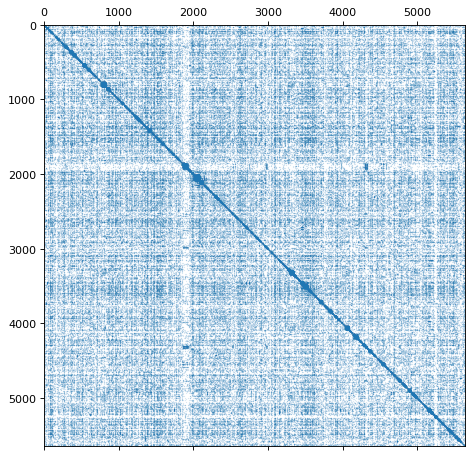

In [22]:
# Vidualize similarity between books
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6), dpi=80)
plt.spy(book_cosine_sim, precision = 0.1, markersize = 0.04)
plt.tight_layout()
plt.show()


---
### Recommendation
- Given a book name, find top n similar books based on cosine similarity score.
1) Series Information
2) Other Books In Numbered Series
3) Theme
4) Author

In [23]:
books = pd.Series(model_data['Name'])

def recommend_books_similar_to(book_name, n=5, cosine_sim_mat=book_cosine_sim):
    # get index of the imput book
    input_idx = books[books == book_name].index[0]
    # Find top n similar books with decreasing order of similarity score
    top_n_books_idx = list(pd.Series(cosine_sim_mat[input_idx]).sort_values(ascending = False).iloc[1:n+1].index)
    # [1:6] to exclude 0 (index 0 is the input movie itself)

    books_list = list(books)
    recommended_books = [books[i] for i in top_n_books_idx]

    return recommended_books

In [24]:
# Recommendations with series information
print("\033[1m{}\033[0m".format("Recommendation (Series Information) based on the read: The Eastland Disaster (Images of America: Illinois)"))
display(recommend_books_similar_to("the eastland disaster (images of america: illinois)", 5))

# Recommendations with series information numbered
print("\n\033[1m{}\033[0m".format("Recommendation (Numbered Series) based on the read: The Majolica Murders (Antique Lover, #5)"))
display(recommend_books_similar_to("the majolica murders (antique lover, #5)", 5))

print("\n\033[1m{}\033[0m".format("Recommendation (Theme: Programming) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)"))
display(recommend_books_similar_to('the practice of programming (addison-wesley professional computing series)', 5))

print("\n\033[1m{}\033[0m".format("Recommendation (Author: Dean Koontz) based on the read: Cold Fire"))
display(recommend_books_similar_to("cold fire",5))

Recommendation (Series Information) based on the read: The Eastland Disaster (Images of America: Illinois)


['forgotten chicago (images of america: illinois)',
 'trenton (images of america: new jersey)',
 "altgeld's america",
 'cell',
 'magnificent but not war: the battle of ypres, 1915']


Recommendation (Numbered Series) based on the read: The Majolica Murders (Antique Lover, #5)


['four on the floor (antique lover, #4)',
 'the weedless widow (antique lover, #2)',
 'the marriage casket (antique lover, #3)',
 'the body in the bookcase (faith fairchild, #9)',
 'out of control (mcclouds & friends #3)']


Recommendation (Theme: Programming) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)


['data structures & other objects using java',
 'simply scheme: a methods handbook',
 'the reasoned schemer',
 'nlp solutions: how to model what works in business and make it work for you',
 'java in a nutshell (in a nutshell)']


Recommendation (Author: Dean Koontz) based on the read: Cold Fire


['false memory',
 'the door to december',
 'darkfall',
 'forever odd (odd thomas, #2)',
 'whispers']

In [25]:
!pip install flask pyngrok


In [26]:
import os

os.makedirs('templates', exist_ok=True)

with open('templates/index.html', 'w') as f:
    f.write("""
    <!DOCTYPE html>
<html lang="en">

<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Book Recommendation System</title>
    <!-- Bootstrap CSS -->
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-KyZXEJxv+7+0mTjpQ5Cw1TAfN1zht4z2zv3DDM51wje0fBzMslg5iv2IuhOq4Vc6" crossorigin="anonymous">
    <style>
        body {
            background-color: #f4f7fa;
            font-family: 'Arial', sans-serif;
        }

        .container {
            max-width: 800px;
            margin-top: 50px;
            background-color: white;
            border-radius: 10px;
            padding: 30px;
            box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.1);
        }

        h1 {
            color: #3d3d3d;
        }

        label {
            font-size: 1.2em;
        }

        .btn-primary {
            background-color: #007bff;
            border-color: #007bff;
        }

        .btn-primary:hover {
            background-color: #0056b3;
            border-color: #0056b3;
        }

        .book-list {
            margin-top: 30px;
        }

        .book-list ul {
            list-style-type: none;
            padding-left: 0;
        }

        .book-list li {
            background-color: #f8f9fa;
            padding: 10px;
            border-radius: 5px;
            margin: 5px 0;
            font-size: 1.1em;
        }

        .book-list li:hover {
            background-color: #e2e6ea;
        }

        .form-control {
            font-size: 1.1em;
        }

        .alert {
            background-color: #f8d7da;
            color: #721c24;
            padding: 15px;
            border-radius: 5px;
        }

    </style>
</head>

<body>
    <div class="container">
        <h1 class="text-center mb-4">Book Recommendation System</h1>

        <!-- Form for user input -->
        <form method="POST">
            <div class="mb-3">
                <label for="book_name" class="form-label">Enter a Book Name</label>
                <input type="text" id="book_name" name="book_name" class="form-control" placeholder="e.g., The Great Gatsby" required>
            </div>
            <button type="submit" class="btn btn-primary w-100">Get Recommendations</button>
        </form>

        {% if book_name %}
        <div class="book-list">
            <h2 class="mt-4">Recommendations based on "{{ book_name }}":</h2>
            <ul>
                {% for book in recommended_books %}
                <li>{{ book }}</li>
                {% endfor %}
            </ul>
        </div>
        {% endif %}
    </div>

    <!-- Bootstrap JS and dependencies -->
    <script src="https://cdn.jsdelivr.net/npm/@popperjs/core@2.11.6/dist/umd/popper.min.js" integrity="sha384-oBqDVmMz4fnFO9gybGQAA3l7i3f3l8duWl/0HRl5oOOiFdJbYfF4JgZ3fCZ7Jw/+"></script>
    <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/js/bootstrap.min.js" integrity="sha384-pzjw8f+ua7Kw1TIq0v8Fq9a2YqC/g4yBrTxD76fFv1zLqexGpaE6j9+y8fAoEJjH"></script>
</body>

</html>

    """)


In [ ]:
!pip install flask pyngrok --quiet

from pyngrok import ngrok, conf
from flask import Flask, render_template, request
import joblib
import pandas as pd
import os

# Optional: create 'templates' folder and index.html if not already present
os.makedirs("templates", exist_ok=True)
with open("templates/index.html", "w") as f:
    f.write("""
        <!DOCTYPE html>
<html lang="en">

<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Book Recommendation System</title>
    <!-- Bootstrap CSS -->
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-KyZXEJxv+7+0mTjpQ5Cw1TAfN1zht4z2zv3DDM51wje0fBzMslg5iv2IuhOq4Vc6" crossorigin="anonymous">
    <style>
        body {
            background-color: #f4f7fa;
            font-family: 'Arial', sans-serif;
        }

        .container {
            max-width: 800px;
            margin-top: 50px;
            background-color: white;
            border-radius: 10px;
            padding: 30px;
            box-shadow: 0px 4px 12px rgba(0, 0, 0, 0.1);
        }

        h1 {
            color: #3d3d3d;
        }

        label {
            font-size: 1.2em;
        }

        .btn-primary {
            background-color: #007bff;
            border-color: #007bff;
        }

        .btn-primary:hover {
            background-color: #0056b3;
            border-color: #0056b3;
        }

        .book-list {
            margin-top: 30px;
        }

        .book-list ul {
            list-style-type: none;
            padding-left: 0;
        }

        .book-list li {
            background-color: #f8f9fa;
            padding: 10px;
            border-radius: 5px;
            margin: 5px 0;
            font-size: 1.1em;
        }

        .book-list li:hover {
            background-color: #e2e6ea;
        }

        .form-control {
            font-size: 1.1em;
        }

        .alert {
            background-color: #f8d7da;
            color: #721c24;
            padding: 15px;
            border-radius: 5px;
        }

    </style>
</head>

<body>
    <div class="container">
        <h1 class="text-center mb-4">Book Recommendation System</h1>

        <!-- Form for user input -->
        <form method="POST">
            <div class="mb-3">
                <label for="book_name" class="form-label">Enter a Book Name</label>
                <input type="text" id="book_name" name="book_name" class="form-control" placeholder="e.g., The Great Gatsby" required>
            </div>
            <button type="submit" class="btn btn-primary w-100">Get Recommendations</button>
        </form>

        {% if book_name %}
        <div class="book-list">
            <h2 class="mt-4">Recommendations based on "{{ book_name }}":</h2>
            <ul>
                {% for book in recommended_books %}
                <li>{{ book }}</li>
                {% endfor %}
            </ul>
        </div>
        {% endif %}
    </div>

    <!-- Bootstrap JS and dependencies -->
    <script src="https://cdn.jsdelivr.net/npm/@popperjs/core@2.11.6/dist/umd/popper.min.js" integrity="sha384-oBqDVmMz4fnFO9gybGQAA3l7i3f3l8duWl/0HRl5oOOiFdJbYfF4JgZ3fCZ7Jw/+"></script>
    <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/js/bootstrap.min.js" integrity="sha384-pzjw8f+ua7Kw1TIq0v8Fq9a2YqC/g4yBrTxD76fFv1zLqexGpaE6j9+y8fAoEJjH"></script>
</body>

</html>

    """)

# Load the models
with open('tfidf_model.pkl', 'rb') as f:
    tfidf = joblib.load(f)

book_cosine_sim = joblib.load('cosine_similarity_matrix.pkl')  # Load the cosine similarity matrix
model_data = pd.read_csv("keywords.csv")  # Load your data
books = pd.Series(model_data['Name'])  # The list of book names

app = Flask(__name__)

# Function to recommend books
def recommend_books_similar_to(book_name, n=5, cosine_sim_mat=book_cosine_sim):
    try:
        input_idx = books[books == book_name].index[0]
        top_n_books_idx = list(pd.Series(cosine_sim_mat[input_idx]).sort_values(ascending=False).iloc[1:n+1].index)
        recommended_books = [books[i] for i in top_n_books_idx]
        return recommended_books
    except IndexError:
        return ["Book not found. Please try another title."]

@app.route("/", methods=["GET", "POST"])
def index():
    if request.method == "POST":
        book_name = request.form["book_name"]
        recommended_books = recommend_books_similar_to(book_name)
        return render_template("index.html", book_name=book_name, recommended_books=recommended_books)
    return render_template("index.html", book_name=None, recommended_books=None)

# Start the ngrok tunnel
conf.get_default().auth_token = "2uBD2CqduKQU5ymo5jKFrj46beE_RyCDtRV1gMDxAa8r75sd"
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel: {public_url}")

# Start Flask app
app.run(port=5000)


 * ngrok tunnel: NgrokTunnel: "https://a11a-34-125-237-142.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [29/Apr/2025 03:20:34] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Apr/2025 03:20:36] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [29/Apr/2025 03:20:50] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Apr/2025 03:21:01] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Apr/2025 03:21:37] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Apr/2025 03:21:55] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Apr/2025 03:23:07] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Apr/2025 03:23:36] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Apr/2025 03:23:48] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Apr/2025 03:24:08] "POST / HTTP/1.1" 200 -


In [ ]:
!pip install flask pyngrok --quiet

from pyngrok import ngrok, conf
from flask import Flask, render_template, request
import joblib
import pandas as pd
import os

# Optional: create 'templates' folder and index.html if not already present
os.makedirs("templates", exist_ok=True)
with open("templates/index.html", "w") as f:
    f.write("""
   <!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Book Recommendation System</title>
    <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/css/bootstrap.min.css">
</head>
<body>
<div class="container mt-5">
    <h1 class="mb-4">Book Recommendation System</h1>

    <form method="POST">
        <div class="mb-3">
            <label for="bookSelect" class="form-label">Select a Book</label>
            <select class="form-select" id="bookSelect" name="book_name" required>
                <option value="" disabled selected>Select a book</option>
                {% for book in book_list %}
                    <option value="{{ book }}" {% if book == book_name %}selected{% endif %}>{{ book }}</option>
                {% endfor %}
            </select>
        </div>
        <button type="submit" class="btn btn-primary">Get Recommendations</button>
    </form>

    {% if book_name %}
        <h3 class="mt-5">Recommendations based on "{{ book_name }}" :</h3>
        {% if recommended_books and recommended_books[0] != "Book not found. Please try another title." %}
            <ul class="list-group mt-3">
                {% for book in recommended_books %}
                    <li class="list-group-item">{{ book }}</li>
                {% endfor %}
            </ul>
        {% else %}
            <p class="text-danger">Book not found. Please try another title.</p>
        {% endif %}
    {% endif %}
</div>

<script src="https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/js/bootstrap.bundle.min.js"></script>
</body>
</html>




    """)

# Load the models
with open('tfidf_model.pkl', 'rb') as f:
    tfidf = joblib.load(f)

book_cosine_sim = joblib.load('cosine_similarity_matrix.pkl')  # Load the cosine similarity matrix
model_data = pd.read_csv("keywords.csv")  # Load your data
books = pd.Series(model_data['Name'])  # The list of book names

app = Flask(__name__)

# Function to recommend books
def recommend_books_similar_to(book_name, n=5, cosine_sim_mat=book_cosine_sim):
    try:
      book_name_cleaned = book_name.strip().lower()
      matches = books[books.str.strip().str.lower() == book_name_cleaned]

      if matches.empty:
          return ["Book not found. Please try another title."]

      input_idx = matches.index[0]
      top_n_books_idx = list(pd.Series(cosine_sim_mat[input_idx]).sort_values(ascending=False).iloc[1:n+1].index)
      recommended_books = [books[i] for i in top_n_books_idx]
      return recommended_books
    except IndexError:
        return ["Book not found. Please try another title."]

@app.route("/", methods=["GET", "POST"])
def index():
    book_list = books.tolist()  # Convert the Series to a simple list
    recommended_books = None
    selected_book = None

    if request.method == "POST":
        selected_book = request.form["book_name"]
        recommended_books = recommend_books_similar_to(selected_book)

    return render_template("index.html", book_list=book_list, book_name=selected_book, recommended_books=recommended_books)

# Start the ngrok tunnel
conf.get_default().auth_token = "2uBD2CqduKQU5ymo5jKFrj46beE_RyCDtRV1gMDxAa8r75sd"
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel: {public_url}")

# Start Flask app
app.run(port=5000)
